## Load relevant packages

In [169]:
# Import all the required packages
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC, SVR
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, f_classif, RFE, RFECV
from sklearn.semi_supervised import label_propagation
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AffinityPropagation, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import itertools
from copy import deepcopy
import re
%matplotlib inline

## Load relevant data files

In [2]:
#================================================================================================
# USER INPUT!
# Here I specify which data files need reading in
datafilenames = ["natinalitycleantrain.csv"]
# For each data file, we write which column contains the information we want to predict
topredictcolumn= ["Survived"]
#================================================================================================

# FROM HERE ON IT'S AUTOMATIC

# Sometiems the index column gets saved automatically as a new column when writingto csv. 
# We'll remove these as they serve no purpose.
alldataframes = [pd.read_csv(filename) for filename in datafilenames]

for (pos,frame) in enumerate(alldataframes):
    toadd = frame
    if "Unnamed: 0" in frame:
        toadd = toadd.drop("Unnamed: 0",axis=1)
    if "Unnamed: 0.1" in frame:
        toadd = toadd.drop("Unnamed: 0.1",axis=1)
    alldataframes[pos] = toadd

# Temporary work

This particular problem is a classification problem; we are not trying to obtain the value of some parameter, e.g. how much a customer will spend in the future.

However, it might still be useful to try and predict such parameters, e.g. the age of passengers. This might improve survival predictions, but regarless it is a good exercise to do.

In [3]:
thedataframe = deepcopy(alldataframes[0])
datacateg = {'Survived': "QA", 'Pclass': "O", 'Name': "C", 'Sex': "C",
             'Age': "QA", 'SibSp': "QA", 'Parch': "QA", 'Ticket': "C", 
             'Fare': "QA", 'Cabin': "C", 'Embarked': "C", 'Nationality': "C"}
uselesscols = ["Name", "Ticket"]
dictofunknown = {"Survived": -1, "Pclass": -1,"Name": "Unknown name", "Sex": "Unspecified", 
                 "Ticket": "XXXXXX", "Cabin": "X", "Embarked": "X", 
                 "Age": alldataframes[0]["Age"][abs(alldataframes[0]["Age"] - alldataframes[0]["Age"].mean()) < 0.2].unique()[0], 
                 "Nationality": "Unknown"}
orderings = [
    {"Pclass": [1,2,3]} #NB only need to include columns that are not numeric!
]
dictofordinals = {"Pclass": [1,2,3]}

## Regression
### Functions for making predictions based on given model

In [4]:
# Returns the intercept, parameters, Rscore (where 1.0 is perfect prediction, and percentage of cases
# correctly predicted. The final two are given as tuple (score, errorbarsonscore). X is the data we use 
# to predict y; predictionmethod is the name of our model, e.g. linear_model.LinearRegression; rounddecimals
# equals the number of decimals allowed for our prediction, e.g. when predicting integers rounddecimals=0; 
# num_iterations is the number of times we run the function to obtain the parameters, and kwargs are any 
# additional optional parameters we want to pass on to predictionmethod.
def getParametersAndPredictionScore(inputX, inputy, predictionmethod, rounddecimals="none", num_iterations=1, 
                                    classifier=False, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        (X, y) = (transformData(inputX, transform=transform), transformData(inputy, transform=transform))
    if classifier==True:
        predictedpercent = []
    parameters = []
    intercept = []
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            predictedy = predictor.predict(Xtest)
            if rounddecimals!="none":
                predictedy = np.round(predictedy, decimals=rounddecimals)
            if classifier==True:
                predictedpercent.append((predictedy==ytest).mean())
            parameters.append(predictor.coef_)
            intercept.append(predictor.intercept_)
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    parameters = np.mean(parameters, axis=0)
    intercept = np.mean(intercept)
    if classifier==True:
        predictedpercent = (np.mean(predictedpercent), np.std(predictedpercent))
        toreturn = (intercept, parameters, score, predictedpercent)
    else:
        toreturn = (intercept, parameters, score)
    return toreturn

def getPredictionPercentage(inputX, inputy, predictionmethod, rounddecimals="none", num_iterations=1, 
                                    classifier=False, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        (X, y) = (transformData(inputX, transform=transform), transformData(inputy, transform=transform))
    if classifier==True:
        predictedpercent = []
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            predictedy = predictor.predict(Xtest)
            if rounddecimals!="none":
                predictedy = np.round(predictedy, decimals=rounddecimals)
            if classifier==True:
                predictedpercent.append((predictedy==ytest).mean())
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    if classifier==True:
        predictedpercent = (np.mean(predictedpercent), np.std(predictedpercent))
        toreturn = (score, predictedpercent)
    else:
        toreturn = (score)
    return toreturn

# Returns the prediction accuracy (+/- errorbars on the accuracy) when classifying "at random", i.e. 
# by always predicting the same thing for all the elements. We try by predicting the mean, or the 
# median, or the most frequently occurring element
def randomPrediction(y, rounddecimals="none", num_iterations=1):
    meanscore = []
    medianscore = []
    mostfrequentscore = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            ytrain, ytest = y[trainindex], y[testindex]
            mean = np.mean(ytrain)
            median = np.median(ytrain)
            mostfrequent = max(set(list(y)), key=list(ytrain).count)
            if rounddecimals!="none":
                mean = np.round(mean, decimals=rounddecimals)
            meanscore.append((ytest==mean).mean())
            medianscore.append((ytest==median).mean())
            mostfrequentscore.append((ytest==mostfrequent).mean())
    meanscore = (np.mean(meanscore), np.std(meanscore))
    medianscore = (np.mean(medianscore), np.std(medianscore))
    mostfrequentscore = (np.mean(mostfrequentscore), np.std(mostfrequentscore))
    allscores = [meanscore[0], medianscore[0], mostfrequentscore[0]]
    return [meanscore, medianscore, mostfrequentscore][allscores.index(max(allscores))]

#### Helper functions

In [91]:
def brewerColors(listlength=6):
    return ["#1f78b4","#33a02c", "#e31a1c", "#ff7f00", "#6a3d9a", "#b15928"][:min(12,listlength)]

def transformData(inputdata, transform="log"):
    outputdata = deepcopy(inputdata)
    if transform=="sqrt":
        outputdata[outputdata>0] = np.sqrt(outputdata[outputdata>0])
        outputdata[outputdata<0] = -np.sqrt(-outputdata[outputdata<0])
    if transform=="log":
        outputdata[outputdata>1] = np.log(outputdata[outputdata>1])+1
        outputdata[outputdata<-1] = -np.log(-outputdata[outputdata<-1])-1
    return outputdata

def inverseTransformData(inputdata, transform="log"):
    outputdata = deepcopy(inputdata)
    if transform=="sqrt":
        outputdata[outputdata>0] = outputdata[outputdata>0]**2
        outputdata[outputdata<0] = -((-outputdata[outputdata<0])**2)
    if transform=="log":
        outputdata[outputdata>1] = np.e**(outputdata[outputdata>1]-1)
        outputdata[outputdata<-1] = -(np.e**(-outputdata[outputdata<-1] -1))
    return outputdata

def scaleData(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train)  # Need to fit only on training data, not evaluation data!
    scaledX_train = scaler.transform(X_train)
    scaledX_test = scaler.transform(X_test)  # we apply same transformation to test data
    return (scaledX_train, scaledX_test)

#This function removes those rows in "inputdataframe" where data was generated automatially 
# in the column "columnofinterest". "dictofunknown" contains the information on what data was
# generated automatically.
def removeAutogeneratedData(inputdataframe, columnsofinterest, dictofunknown):
    if type(columnsofinterest)==str:
        allcolumnsofinterest = [columnsofinterest]
    else:
        allcolumnsofinterest = columnsofinterest
    outputdataframe = deepcopy(inputdataframe)
    for col in allcolumnsofinterest:
        if col in dictofunknown:
            outputdataframe = outputdataframe[outputdataframe[col]!= dictofunknown[col]]
    return outputdataframe

# Helper function that takes a model, e.g. linear_model.LinearRegression,
# and returns the name of that model, e.g. "LinearRegression"
def getModelName(currentmodel):
    modelname = str(currentmodel)
    modelname = modelname[modelname.rfind(".")+1:]
    extracharacters = re.search("[^a-zA-z]",modelname)
    if type(extracharacters)!=type(None):
        modelname = modelname[:extracharacters.start()]
    return modelname

# Returns the same dataframe but where the ordinal data has been replaced with numbers, and hence can
# be ordered correctly. When plotting it will be necessary to replace the numbers back to their
# original categorical labels.
def orderOrdinalData(thedataframe, dictofordinals):
    orderedordinalsframe = deepcopy(thedataframe)
    # We need to turn the dictionary dictofordinals into a form good for using pandas .replace(dict)
    neworderings = deepcopy(dictofordinals)
    for key in neworderings:
        # Pandas complains if we have intersections between the keys and the values
        intersectionlength = len(set(neworderings[key]).intersection(set(range(1,len(neworderings[key])+1))))
        if intersectionlength==0:
            # We can just replace the entries with 0,1,2,...,num_categories-1
            neworderings[key] = dict([(el,ii+1) for ii,el in enumerate(neworderings[key])])
        else:
            # We replace with '0',1','2',.... instead. We will later turn the strings into ints.
            neworderings[key] = dict([(el,str(ii+1)) for ii,el in enumerate(neworderings[key])])
    # Now we'll replace the ordinal columns in the dataframes with numeric labels
    if dictofordinals!={}:
        orderedordinalsframe.replace(neworderings, inplace=True)
        for key in neworderings.keys():
            orderedordinalsframe.loc[:,key] = pd.to_numeric(orderedordinalsframe[key])
    return (orderedordinalsframe, neworderings)

def makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg):
    ordereddataframe = orderOrdinalData(thedataframe, dictofordinals)[0]
    replacementdict = {}
    for col in ordereddataframe:
        if datacateg[col]=="C":
            allcategories = sorted(ordereddataframe[col].unique())
            replacementdict[col] = dict([(cat,ii) for ii, cat in enumerate(allcategories)])
    ordereddataframe.replace(replacementdict, inplace=True)
    return (ordereddataframe, replacementdict)

### Implement all linear regressions

In [6]:
def tryAllLinearRegressions(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                            rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [linear_model.LinearRegression, linear_model.RidgeCV, linear_model.LassoCV, 
                      linear_model.BayesianRidge, linear_model.SGDRegressor]
    
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDRegressor:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modeldata = getParametersAndPredictionScore(X, y, model, rounddecimals=rounddecimals, 
                                                        num_iterations=num_iterations, n_alphas=3,
                                                        classifier=classifier, transform=transformtouse)
        else:
            modeldata = getParametersAndPredictionScore(X, y, model, rounddecimals=rounddecimals, 
                                                        num_iterations=num_iterations, classifier=classifier,
                                                        transform=transformtouse)
        modelandresults[modelname] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[2]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

# Makes a scatterplot of the error in prediction, versus the predicted value, to see if there
# is any heteroscedasticity, i.e. to see if the error bars of our prediction depend on the value
# of the prediction. Returns the R^2 value of the prediction.
def plotErrors(thedataframe, topredict, frompredict, chosenmodel, dictofregressions, 
               rounddecimals="none", minvalue="none", maxvalue="none", ax="none", dictofunknown={}, 
               alpha=0.3, transform="none"):
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    if transform!="none":
        X = transformData(X, transform=transform)
    coefficients = dictofregressions[chosenmodel][1]
    intercept = dictofregressions[chosenmodel][0]
    prediction = np.dot(X,coefficients) + intercept
    if transform!="none":
        prediction = inverseTransformData(prediction, transform=transform)
    if rounddecimals!="none":
        prediction = np.round(prediction, decimals=rounddecimals)
    if minvalue!="none":
        prediction[prediction < minvalue] = minvalue
    if maxvalue!="none":
        prediction[prediction > maxvalue] = maxvalue
    if ax=="none":
        plt.scatter(prediction, prediction - y, alpha=alpha)
        plt.xlabel("Predicted " + topredict)
        plt.ylabel("Error in prediction")
        plt.show()
    else:
        ax.scatter(prediction, prediction - y, alpha=alpha)
        ax.set_xlabel("Predicted " + topredict)
        ax.set_ylabel("Error in prediction")
    print "Mean: %f" %np.mean(prediction - y)
    print "Std: %f" %np.std(prediction - y)
    print "R^2: %f" %(np.var(prediction) / np.var(y))

#### Helper functions

In [7]:
def makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown):
    tousedataframe = removeAutogeneratedData(thedataframe, frompredict + [topredict], dictofunknown)
    X = tousedataframe[frompredict].as_matrix()
    y = tousedataframe[topredict].as_matrix()
    return (X,y)

### Functions for using regressions to fill in unknown data

In [8]:
# Makes a dataframe where the values of topredict have been predicted using frompredict, with the regression 
# model called chosenmodel (a string). For this we need to have found all regressions, placed in the variable
# dictofregressions.
def incorporateRegressionPrediction(inputdataframe, topredict, frompredict, chosenmodel, dictofregressions,
                                    rounddecimals="none", minvalue="none", maxvalue="none", transform="none"):
    thedataframe = deepcopy(inputdataframe)
    if topredict in dictofunknown:
        topredictframe = thedataframe[thedataframe[topredict]==dictofunknown[topredict]]
    else:
        topredictframe = thedataframe[thedataframe[topredict].isnull()]
    ind = topredictframe.index
    dataX = topredictframe[frompredict].as_matrix()
    if transform!="none":
        dataX = transformData(dataX, transform=transform)
    if len(dataX) > 0:
        coefficients = dictofregressions[chosenmodel][1]
        intercept = dictofregressions[chosenmodel][0]
        prediction = np.dot(dataX,coefficients) + intercept
        if transform!="none":
            prediction = inverseTransformData(prediction, transform=transform)
        if rounddecimals!="none":
            prediction = np.round(prediction, decimals=rounddecimals)
        if minvalue!="none":
            prediction[prediction < minvalue] = minvalue
        if maxvalue!="none":
            prediction[prediction > maxvalue] = maxvalue
        thedataframe.loc[ind, topredict] = prediction
    return thedataframe

### Use linear regression for missing data

After having tried various options, it seems like using transform="log" we're able to avoid most of the heteroscedasticity we otherwise get with a straightforward linear regression.

In [9]:
numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
topredict = "Age"
frompredict = ['Pclass', 'Sex', 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']
tousedataframe = deepcopy(numericdataframe)
transform = "log"

linearregressions = tryAllLinearRegressions(tousedataframe, topredict, frompredict,
                                            dictofunknown={'Age': 29.6991176471}, printout=True, num_iterations=100, 
                                            rounddecimals="none", classifier=False, transform=transform)

LinearRegression
	The score on the fit is 0.228879 ± 0.076990 (1.0 is perfect)
RidgeCV
	The score on the fit is 0.230848 ± 0.074230 (1.0 is perfect)
LassoCV
	The score on the fit is 0.231639 ± 0.072863 (1.0 is perfect)
BayesianRidge
	The score on the fit is 0.227069 ± 0.081478 (1.0 is perfect)
SGDRegressor
	The score on the fit is 0.209609 ± 0.063412 (1.0 is perfect)


### Check heteroscedasticity of fit

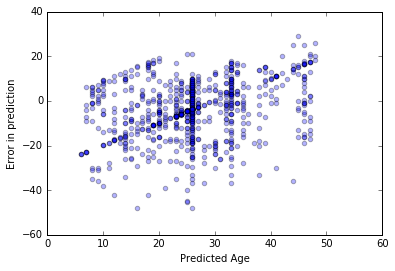

Mean: -3.668175
Std: 12.411154
R^2: 0.492599


In [10]:
chosenmodel = "LinearRegression"
dictofregressions = linearregressions
rounddecimals=0
minvalue=0
maxvalue=100

plotErrors(tousedataframe, topredict, frompredict, chosenmodel, dictofregressions,
           rounddecimals=rounddecimals, minvalue=minvalue, maxvalue=maxvalue, ax="none", transform=transform)

### Make new datafram with predicted values

In [11]:
newdataframe = incorporateRegressionPrediction(tousedataframe, topredict, frompredict, chosenmodel, dictofregressions,
                                               rounddecimals=rounddecimals, minvalue=minvalue, maxvalue=maxvalue, 
                                               transform=transform)

## Classification
### Generic functions for making predictions and checking their accuracy

In [12]:
def getPrediction(trainX, trainy, dataX, predictionmethod, transform="none",**kwargs):
    (Xtraining, ytraining) = (trainX, trainy)
    X = dataX
    if transform!="none":
        Xtraining = transformData(trainX, transform=transform)
        X = transformData(dataX, transform=transform)
    if transform=="scale":
        (Xtraining, X) = scaleData(Xtraining, X)
    predictor = predictionmethod(**kwargs)
    predictor.fit(Xtraining,ytraining)
    predictedy = predictor.predict(X)
    return predictedy

def getPredictionProba(trainX, trainy, dataX, predictionmethod, transform="none",**kwargs):
    (Xtraining, ytraining) = (trainX, trainy)
    X = dataX
    if transform!="none":
        Xtraining = transformData(trainX, transform=transform)
        X = transformData(dataX, transform=transform)
    if transform=="scale":
        (Xtraining, X) = scaleData(Xtraining, X)
    predictor = predictionmethod(**kwargs)
    predictor.fit(Xtraining,ytraining)
    predictedy = predictor.predict_proba(X)
    return predictedy

def getPredictionScore(inputX, inputy, predictionmethod, num_iterations=1, transform="none",**kwargs):
    (X, y) = (inputX, inputy)
    if transform!="none":
        X = transformData(inputX, transform=transform)
    score = []
    for iter in range(num_iterations):
        kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
        for trainindex, testindex in kfoldindices:
            Xtrain, Xtest = X[trainindex], X[testindex]
            if transform=="scale":
                (Xtrain, Xtest) = scaleData(Xtrain, Xtest)
            ytrain, ytest = y[trainindex], y[testindex]
            predictor = predictionmethod(**kwargs)
            predictor.fit(Xtrain,ytrain)
            score.append(predictor.score(Xtest,ytest))
    score = (np.mean(score),np.std(score))
    return score

### Functions for making classification through regression

In [13]:
def tryAllLinRegClassifiers(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=30, 
                            rounddecimals=0, printout=True, transform="scale", polynomialdegrees=[1]):
    linregs = tryPolynomialRegressions(thedataframe, topredict, frompredict, polynomialdegrees,
                                       dictofunknown=dictofunknown, num_iterations=num_iterations,
                                       rounddecimals=rounddecimals, printout=printout, classifier=True, transform=transform)
    otherregs = tryOtherRegressions(thedataframe, topredict, frompredict,
                                    dictofunknown=dictofunknown, num_iterations=num_iterations,
                                    rounddecimals=rounddecimals, printout=printout, classifier=True, transform="none")
    linregs.update(otherregs)
    regclassifiers = tryAllRegressionClassifiers(thedataframe, topredict, frompredict, polynomialdegrees, 
                                                 dictofunknown=dictofunknown, num_iterations=num_iterations, 
                                                 printout=printout, transform=transform)
    linregs.update(regclassifiers)
    otherclass = tryOtherClassifiers(thedataframe, topredict, frompredict, dictofunknown=dictofunknown, 
                                     num_iterations=num_iterations, printout=printout, transform=transform)
    linregs.update(otherclass)
    return linregs

#### Helper functions

In [14]:
def tryAllRegressionClassifiers(thedataframe, topredict, frompredict, polynomialdegrees, dictofunknown={}, num_iterations=100, 
                            printout=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [linear_model.LogisticRegression, linear_model.LogisticRegressionCV, linear_model.SGDClassifier,
                      linear_model.Perceptron]
    
    if type(polynomialdegrees)==int:
        alldegrees = [polynomialdegrees]
    else:
        alldegrees = polynomialdegrees
    
    randomprediction = randomPrediction(y, num_iterations=num_iterations)
    
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDClassifier or model==linear_model.Perceptron:
            transformtouse = "scale"
        for polydegree in alldegrees:
            poly = PolynomialFeatures(degree=polydegree)
            polyX = poly.fit_transform(X)
            if printout==True:
                print "\tPolynomial of degree " + str(polydegree)
            if "n_alphas" in model().get_params(): 
                modelscore = getPredictionScore(polyX, y, model, num_iterations=num_iterations, n_alphas=3, 
                                                transform=transformtouse)
            else:
                modelscore = getPredictionScore(polyX, y, model, num_iterations=num_iterations, transform=transformtouse)
            modelandresults[modelname] = modelscore
            if printout==True:
                print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
                print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
            # Now we'll do the Bagging version of this same model
            if printout==True:
                print "\t    Bagging version"
            if "n_alphas" in model().get_params(): 
                modelscore = getPredictionScore(X, y, BaggingClassifier, num_iterations=2, transform=transformtouse,
                                            base_estimator=model(n_alphas=3), n_estimators=30)
            else:
                modelscore = getPredictionScore(X, y, BaggingClassifier, num_iterations=2, transform=transformtouse,
                                            base_estimator=model(), n_estimators=30)
            modelandresults[("Bagging " + modelname)] = modelscore
            if printout==True:
                print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
                print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryPolynomialRegressions(thedataframe, topredict, frompredict, polynomialdegrees, dictofunknown={}, num_iterations=100, 
                             rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [linear_model.LinearRegression, linear_model.RidgeCV, linear_model.LassoCV, 
                      linear_model.BayesianRidge, linear_model.SGDRegressor]
    
    if type(polynomialdegrees)==int:
        alldegrees = [polynomialdegrees]
    else:
        alldegrees = polynomialdegrees
    
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDRegressor or model==linear_model.Perceptron:
            transformtouse = "scale"
        for polydegree in alldegrees:
            poly = PolynomialFeatures(degree=polydegree)
            polyX = poly.fit_transform(X)
            if printout==True:
                print "\tPolynomial of degree " + str(polydegree)
            if "n_alphas" in model().get_params():
                modeldata = getPredictionPercentage(polyX, y, model, rounddecimals=rounddecimals, 
                                                            num_iterations=num_iterations, n_alphas=3,
                                                            classifier=classifier, transform=transformtouse)
            else:
                modeldata = getPredictionPercentage(polyX, y, model, rounddecimals=rounddecimals, 
                                                            num_iterations=num_iterations, classifier=classifier,
                                                            transform=transformtouse)
            modelandresults[(modelname,polydegree)] = modeldata
            if printout==True:
                print u"\t\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[-2]
                if classifier==True:
                    print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                    print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
            # Now we'll do the Bagging version of this same model
            if printout==True:
                print "\t    Bagging version"
            if "n_alphas" in model().get_params(): 
                modeldata = getPredictionPercentage(polyX, y, BaggingRegressor, rounddecimals=rounddecimals, 
                                                             num_iterations=2, classifier=classifier,
                                                             transform=transformtouse, base_estimator=model(n_alphas=3),
                                                             n_estimators=30)
            else:
                modeldata = getPredictionPercentage(polyX, y, BaggingRegressor, rounddecimals=rounddecimals, 
                                                             num_iterations=2, classifier=classifier,
                                                             transform=transformtouse, base_estimator=model(),
                                                             n_estimators=30)
            modelandresults[("Bagging " + modelname)] = modeldata
            if printout==True:
                print u"\t\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[-2]
                if classifier==True:
                    print u"\t\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                    print u"\t\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryOtherRegressions(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                        rounddecimals="none", printout=False, classifier=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [KernelRidge, GaussianProcessRegressor]
       
    if classifier==True:
        randomprediction = randomPrediction(y, rounddecimals=rounddecimals, num_iterations=num_iterations)
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDRegressor or model==linear_model.Perceptron:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modeldata = getPredictionPercentage(X, y, model, rounddecimals=rounddecimals, 
                                                num_iterations=num_iterations, n_alphas=3,
                                                classifier=classifier, transform=transformtouse)
        else:
            modeldata = getPredictionPercentage(X, y, model, rounddecimals=rounddecimals, 
                                                num_iterations=num_iterations, classifier=classifier,
                                                transform=transformtouse)
        modelandresults[modelname] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[-2]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
        # Now we'll do the Bagging version of this same model
        if printout==True:
            print "    Bagging version"
        if "n_alphas" in model().get_params(): 
            modeldata = getPredictionPercentage(X, y, BaggingRegressor, rounddecimals=rounddecimals, 
                                                num_iterations=2, classifier=classifier,
                                                transform=transformtouse, base_estimator=model(n_alphas=3),
                                                n_estimators=30)
        else:
            modeldata = getPredictionPercentage(X, y, BaggingRegressor, rounddecimals=rounddecimals, 
                                                num_iterations=2, classifier=classifier,
                                                transform=transformtouse, base_estimator=model(),
                                                n_estimators=30)
        modelandresults[("Bagging " + modelname)] = modeldata
        if printout==True:
            print u"\tThe score on the fit is %f \u00B1 %f (1.0 is perfect)" %modeldata[-2]
            if classifier==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modeldata[-1]
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

def tryOtherClassifiers(thedataframe, topredict, frompredict, dictofunknown={}, num_iterations=100, 
                            printout=False, transform="none"):
    # We begin by making the input data from thedataframe
    (X,y) = makeDataFromModels(thedataframe, topredict, frompredict, dictofunknown)
    
    modelstotryout = [SVC, KNeighborsClassifier, NearestCentroid, GaussianProcessClassifier, GaussianNB, 
                      DecisionTreeClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,
                      GradientBoostingClassifier]
      
    randomprediction = randomPrediction(y, num_iterations=num_iterations)
    
    modelandresults = {}
    for model in modelstotryout:
        modelname = getModelName(model)
        if printout==True:
            print modelname
        transformtouse = transform
        if model==linear_model.SGDClassifier or model==linear_model.Perceptron or model==SVC:
            transformtouse = "scale"
        if "n_alphas" in model().get_params():
            modelscore = getPredictionScore(X, y, model, num_iterations=num_iterations, n_alphas=3, 
                                            transform=transformtouse)
        else:
            modelscore = getPredictionScore(X, y, model, num_iterations=num_iterations, transform=transformtouse)
        modelandresults[modelname] = modelscore
        if printout==True:
            print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
            print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
        # Now we'll do the Bagging version of this same model
        if model!=RandomForestClassifier and model!=ExtraTreesClassifier:
            if printout==True:
                print "    Bagging version"
            if "n_alphas" in model().get_params(): 
                modelscore = getPredictionScore(X, y, BaggingClassifier, num_iterations=2, transform=transformtouse,
                                            base_estimator=model(n_alphas=3), n_estimators=30)
            else:
                modelscore = getPredictionScore(X, y, BaggingClassifier, num_iterations=2, transform=transformtouse,
                                            base_estimator=model(), n_estimators=30)
            modelandresults[("Bagging " + modelname)] = modelscore
            if printout==True:
                print u"\tThe percentage of correct identifications is: %f \u00B1 %f" %modelscore
                print u"\t         Benchmark from random prediction is: %f \u00B1 %f" %randomprediction
    return modelandresults

In [15]:
topredict = "Survived"
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']

allmodelsandresults = tryAllLinRegClassifiers(numericdataframe, topredict, frompredict, num_iterations=10, 
                        transform="scale", polynomialdegrees=[1,2,3])

LinearRegression
	Polynomial of degree 1
		The score on the fit is 0.383243 ± 0.065048 (1.0 is perfect)
		The percentage of correct identifications is: 0.791469 ± 0.030144
		         Benchmark from random prediction is: 0.610743 ± 0.034591
	    Bagging version
		The score on the fit is 0.387069 ± 0.069074 (1.0 is perfect)
		The percentage of correct identifications is: 0.792799 ± 0.025757
		         Benchmark from random prediction is: 0.610743 ± 0.034591
	Polynomial of degree 2
		The score on the fit is 0.400357 ± 0.064851 (1.0 is perfect)
		The percentage of correct identifications is: 0.808009 ± 0.032541
		         Benchmark from random prediction is: 0.610743 ± 0.034591
	    Bagging version
		The score on the fit is 0.391988 ± 0.076078 (1.0 is perfect)
		The percentage of correct identifications is: 0.811630 ± 0.038480
		         Benchmark from random prediction is: 0.610743 ± 0.034591
	Polynomial of degree 3
		The score on the fit is -2324871405332914503680.000000 ± 16269709327984

C:\Users\Daniele\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


		The score on the fit is 0.407768 ± 0.056624 (1.0 is perfect)
		The percentage of correct identifications is: 0.812329 ± 0.027881
		         Benchmark from random prediction is: 0.610743 ± 0.034591
	    Bagging version
		The score on the fit is 0.415655 ± 0.036060 (1.0 is perfect)
		The percentage of correct identifications is: 0.817899 ± 0.020535
		         Benchmark from random prediction is: 0.610743 ± 0.034591
	Polynomial of degree 3
		The score on the fit is 0.405937 ± 0.074618 (1.0 is perfect)
		The percentage of correct identifications is: 0.812338 ± 0.029311
		         Benchmark from random prediction is: 0.610743 ± 0.034591
	    Bagging version
		The score on the fit is 0.399471 ± 0.096720 (1.0 is perfect)
		The percentage of correct identifications is: 0.813364 ± 0.024162
		         Benchmark from random prediction is: 0.610743 ± 0.034591
BayesianRidge
	Polynomial of degree 1
		The score on the fit is 0.385770 ± 0.044067 (1.0 is perfect)
		The percentage of correct identific

In [15]:
numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
topredict = "Survived"
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']

(X,y) = makeDataFromModels(numericdataframe, topredict, frompredict, {})
getPredictionScore(X, y, SVC, num_iterations=20, transform="scale")

(0.81574935064935061, 0.029911660738519343)

### Neural Networks

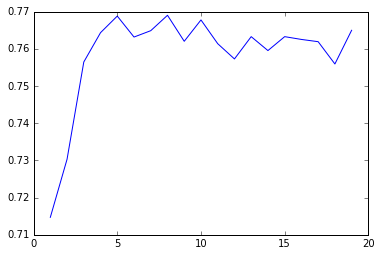

In [137]:
def makeitofsize(dathirdsize):
    allofthem = []
    for ii in range(40):
        neurnet = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(4,9,dathirdsize))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        neurnet.fit(X_train, y_train)
        allofthem.append(np.mean(neurnet.predict(X_test)==y_test))
    return np.mean(allofthem)

allthescores = [makeitofsize(jj) for jj in range(1,20)]
plt.plot(range(1,20),allthescores)

In [138]:
neurnet = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(100,10))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
# It's important to scale the data!
X_train, X_test = scaleData(X_train, X_test)
neurnet.fit(X_train, y_train)
np.mean(neurnet.predict(X_test)==y_test)

0.75035663338088443

#### Find ideal number of neighbors

In [16]:
numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
frompredict = ['Pclass', 'Sex', "Age", 'SibSp', 'Parch', "Fare", "Cabin", 'Embarked']
#frompredict = ['Pclass', 'Sex', 'SibSp']

(X,y) = makeDataFromModels(numericdataframe, topredict, frompredict, {})
allscores = []
for jj in range(1,20):
    allscores.append(getPredictionScore(X, y, KNeighborsClassifier, num_iterations=30, transform="scale", n_neighbors=jj)[0])

# if we decrease wrt a value twice in a row, we've reached the max
bestnumneighbors = list(np.append(
    (np.array(allscores[2:]) - np.array(allscores[:-2]) < 0).astype(int), 
    1) * (np.array(allscores[1:]) - np.array(allscores[:-1]) < 0).astype(int)).index(1) + 1

Ideal number is 13


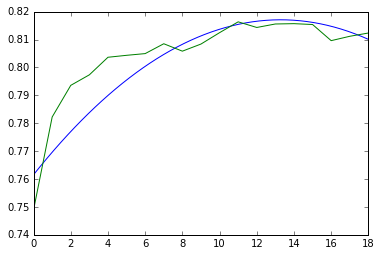

In [17]:
poly = PolynomialFeatures(degree=2)
polyX = poly.fit_transform((np.arange(len(allscores))+1).reshape(-1, 1))
linreg = linear_model.LinearRegression()
linreg.fit(polyX,np.array(allscores).reshape(-1, 1))
xs = np.linspace(0,18)
plt.plot(xs, linreg.intercept_ + linreg.coef_[0][0] + linreg.coef_[0][1]*xs + linreg.coef_[0][2]*(xs**2))
plt.plot(allscores)
print "Ideal number is %d" %np.round(-linreg.coef_[0][1]/(2*linreg.coef_[0][2]))

### Ensemble

In [19]:
def getPredictAccur(predictionmethod):
    try:
        predictionaccuracy = allmodelsandresults[(getModelName(predictionmethod),polydegree)][-1][0]
    except KeyError:
        predictionaccuracy = allmodelsandresults[getModelName(predictionmethod)][0]
    return predictionaccuracy

# ================================================
# THESE FUNCTIONS ARE FOR ESTIMATING THE CORRECT VALUES BASED ON A BAYES-LIKE PROB OF THE RIGHT ANSWER
def getprob(result, event, prob):
    if result==event:
        chance = prob 
    else:
        chance = 1 - prob
    return chance

def getConsensusResult(resultlist, probs):
    prob1 = [getprob(result, 1,prob) for prob,result in zip(probs,resultlist)]
    prob0 = [getprob(result, 0,prob) for prob,result in zip(probs,resultlist)]
    #ratio = (np.mean(y)/(1-np.mean(y)))* np.prod(prob1)/np.prod(prob0)
    ratio = np.prod(prob1)/np.prod(prob0)
    probshouldbe1 = ratio / (1+ratio)
    consensusresult = np.round(probshouldbe1)
    return consensusresult
# ================================================

num_iterations = 10
polydegree = 2
modelstotryout = [linear_model.RidgeCV, linear_model.SGDRegressor, linear_model.LogisticRegression, 
                  SVC, KNeighborsClassifier, NearestCentroid, RandomForestClassifier, ExtraTreesClassifier,
                  AdaBoostClassifier, GradientBoostingClassifier]

poly = PolynomialFeatures(degree=polydegree)
probs = [getPredictAccur(predictionmethod) for predictionmethod in modelstotryout]
totalvotes = np.sum(probs)
score = []
for iter in range(num_iterations):
    kfoldindices = KFold(len(y),n_folds=5,shuffle=True)
    for trainindex, testindex in kfoldindices:
        Xtrain, Xtest = X[trainindex], X[testindex]
        ytrain, ytest = y[trainindex], y[testindex]
        ensemblepredictions = []
        for predictionmethod in modelstotryout:
            if predictionmethod in [linear_model.RidgeCV, linear_model.SGDRegressor, linear_model.LogisticRegressionCV]:
                Xtraintouse = poly.fit_transform(Xtrain)
                Xtesttouse = poly.fit_transform(Xtest)
            else:
                Xtraintouse, Xtesttouse = Xtrain, Xtest
            (Xtraintouse, Xtesttouse) = scaleData(Xtraintouse, Xtesttouse)
            #if predictionmethod==DecisionTreeClassifier:
            #    predictor = predictionmethod(max_depth=6, min_samples_leaf=5)
            #elif predictionmethod==KNeighborsClassifier:
            #    predictor = predictionmethod(n_neighbors=14)
            #else:
            #    predictor = predictionmethod()
            predictor = predictionmethod()
            predictor.fit(Xtraintouse,ytrain)
            predictionaccuracy = getPredictAccur(predictionmethod)
            prediction = np.round(predictor.predict(Xtesttouse), decimals=0)*predictionaccuracy
            ensemblepredictions.append(prediction)
        masterprediction = np.round(np.dot(np.transpose(np.array(ensemblepredictions)), 
                                           np.full(len(modelstotryout), 1.0)) / totalvotes)
        # ================================================
        # ALTERNATIVE METHOD, USING A BAYES-LIKE PROBABILITY ESTIMATE FOR WHICH ANSWER IS RIGHT
        #rounded = np.round(np.transpose(np.array(ensemblepredictions)))
        #masterprediction = np.array([getConsensusResult(resultlist,probs) for resultlist in rounded])
        # ================================================
        score.append(np.mean(masterprediction==ytest))
        
(np.mean(score),np.std(score))

(0.82166623376623382, 0.027986421212895671)

In [296]:
# HERE IS SOMETHING THAT DOES NEARLY EXACTLY THE SAME THING (EXCEPT A LESS PRECISE COMPUTATION OF SCORES)
def daname(clf):
    return str(clf)[:str(clf).index("(")]

Xscaled = scaleData(X,X)[0]

clf2 = linear_model.LogisticRegression()
clf3 = SVC()
clf4 = KNeighborsClassifier()
clf5 = NearestCentroid()
clf6 = RandomForestClassifier(n_estimators=30)
clf7 = ExtraTreesClassifier()
clf8 = AdaBoostClassifier()
clf9 = GradientBoostingClassifier()
theweights = [allmodelsandresults[daname(clf)][0] for clf in [clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9]]
allscores = np.array([])
for ii in range(10):
    ensemble = VotingClassifier(estimators=[('2', clf2), ('3', clf3), ('4', clf4), ('5', clf5), 
                                        ('6', clf6), ('7', clf7), ('8', clf8), ('9', clf9)], voting='hard', weights=theweights)
    scores = cross_val_score(ensemble, Xscaled, y, cv=5)
    allscores = np.append(allscores,scores)
(np.mean(allscores), np.std(allscores))

NameError: name 'allmodelsandresults' is not defined

In [21]:
# IT WORKS ALSO WITH GRIDCV!
ensemble = VotingClassifier(estimators=[('2', clf2), ('3', clf3),  ('4', clf4),  ('5', clf5), 
                                        ('6', clf6), ('7', clf7), ('8', clf8), ('9', clf9)], voting='hard', weights=theweights)
params = {'2__C': [1.0, 100.0], '6__n_estimators': [20, 100]}
grid = GridSearchCV(estimator=ensemble, param_grid=params, cv=5)
np.mean(cross_val_score(grid, Xscaled, y, cv=5))

0.82535714285714301

## Semi-supervised
Semi-supervised methods are when we have a very small amount of labeled data. The way we label the rest of the data is by similarity, often using K-nearest-neighobrs. The unlabeled data should have the $y$-value set to -1

In [18]:
y_unlabeled = deepcopy(y)
# Now we hide 80% of the answers y, and see if we can predict them
indextoremovelabel = np.random.choice(range(len(y_unlabeled)), size=int(0.8*len(y_unlabeled)), replace=False)
y_unlabeled[indextoremovelabel] = -1

In [19]:
spreading = label_propagation.LabelSpreading(kernel='rbf')
spreading.fit(X, y_unlabeled)
print np.mean(spreading.transduction_==y) # The transduction attribute tells you what the predicted labels are

spreading = label_propagation.LabelSpreading(kernel='knn', n_neighbors=7)
spreading.fit(X, y_unlabeled)
print np.mean(spreading.transduction_==y)

propagation = label_propagation.LabelPropagation(kernel='rbf')
propagation.fit(X, y_unlabeled)
print np.mean(propagation.transduction_==y)

propagation = label_propagation.LabelPropagation(kernel='knn')
propagation.fit(X, y_unlabeled)
print np.mean(propagation.transduction_==y)

0.697488584475
0.728310502283
0.684931506849
0.681506849315


### Evaluate and improve Probability estimates

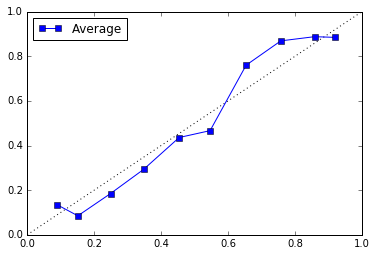

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

# When CalibratedClassifierCV fits the data it first splits it into 3 (or the number cv=#). It
# then leaves out one part, fits the estimator (e.g. Random Forests) to the rest, and evaluates
# the probabilities of the part left out. It then checks how good those probability estimates were,
# by checking whether those predicted with probability 0.1 really did happen 10% of the time etc.
# Once it knows how its probability estimates did it learns how to compensate for its estimates.
# This same procedure is cycled through all 3 folds. We have now created a set of 3 estimators, each
# one that knows how to compensate its probability predictions. 
# When we then use CalibratedClassifierCV to predict probabilities of a test set. Then, each of the
# 3 estimators independently estimates the probability, compensating in its own way, and the 
# average of these results is takes as the true estimate.
# If we want to set cv=1, i.e. to only have a single calibrated estimator, we just feed it
# an already-fitted base estimator and set cv="prefit". Then when we fit this calibrated
# estimator, we must use data that wasn't used to fit the base estimator. Finally, we 
# use yet-unseen data to set it, as normal.

est = RandomForestClassifier(n_estimators=10)
calibratediso = CalibratedClassifierCV(est, method='isotonic')
calibratedsig = CalibratedClassifierCV(est, method='sigmoid')

plt.plot([0,1],[0,1], "k:")
for clf in [est, calibratediso, calibratedsig]:
    clf.fit(X_train, y_train)
    prob_pos = clf.predict_proba(X_test)[:, 1]
    answers, probas = calibration_curve(y_test, prob_pos, n_bins=10)
    #plt.plot(probas, answers, "s-", label = daname(str(clf)))

averagecalibration = (calibratediso.predict_proba(X_test)+calibratedsig.predict_proba(X_test))/2.
answers, probas = calibration_curve(y_test, averagecalibration[:, 1], n_bins=10)
plt.plot(probas, answers, "s-", label = "Average")
plt.legend(loc="upper left")

## Unsupervised - Clustering

#### Evaluation of model - if cluster answer is known (i.e. we have a y)

In [20]:
# Check for each cluster what the average value of y is. Then check in the predicted test sample whether they have the
# same average value of y. Compute the difference between these two in each cluster and output the average and std.
def genericnumbererror(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        trainingmeans = np.array([np.mean([y_train[ii] for ii,label in enumerate(clf.predict(X_train)) if label==kk]) 
                                  for kk in list(set(clf.labels_))])
        testmeans = np.array([np.mean([y_test[ii] for ii,label in enumerate(clf.predict(X_test)) if label==kk])
                              for kk in list(set(clf.labels_))])
        mistake = trainingmeans - testmeans
        mistake = mistake[np.logical_not(np.isnan(mistake))]
        everything.append([np.mean(mistake), np.std(mistake)])
    return np.mean(np.array(everything)[:,0]), np.mean(np.array(everything)[:,1])

def genericnumbererrorFitPredict(method, **kwargs):
    everything = []
    for ij in range(20):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        X_1, X_2, y_1, y_2 = train_test_split(clf.fit_predict(X_touse), y, test_size=0.5)
        X1means = np.array([np.mean([y_1[ii] for ii,label in enumerate(X_1) if label==kk]) 
                                  for kk in list(set(np.append(X_1, X_2)))])
        X2means = np.array([np.mean([y_2[ii] for ii,label in enumerate(X_2) if label==kk]) 
                            for kk in list(set(np.append(X_1, X_2)))])
        mistake = X1means - X2means
        mistake = mistake[np.logical_not(np.isnan(mistake))]
        everything.append([np.mean(mistake), np.std(mistake)])
    return np.mean(np.array(everything)[:,0]), np.mean(np.array(everything)[:,1])

In [21]:
print genericnumbererror(KMeans, n_clusters=2) # Use MiniBatchKMeans is Kmeans is too slow
print genericnumbererror(AffinityPropagation)
print genericnumbererror(MeanShift)
print genericnumbererrorFitPredict(SpectralClustering)
print genericnumbererrorFitPredict(AgglomerativeClustering, n_clusters=2)
print genericnumbererrorFitPredict(DBSCAN)
print genericnumbererror(Birch)

(-0.0088139948430197099, 0.038286649811250455)
(-0.0063040219238520972, 0.19437928483556322)
(-0.010962148029796235, 0.22019678139891946)
(0.010560566640498321, 0.18641111774802366)
(0.011917019469566227, 0.030222250652409337)
(0.0043128022605910844, 0.2764772821286739)
(0.0013113583670082746, 0.065528009303564089)


In [22]:
# This is the benchmark we need to beat
allrandomdifferences = []
for ki in range(1000):
    y_1, y_2 = train_test_split(y, test_size=0.5)
    allrandomdifferences.append(np.mean(y_1)-np.mean(y_2))
np.mean(allrandomdifferences), np.std(allrandomdifferences)

(-0.0017123287671232869, 0.033198380409168643)

In [26]:
def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        everything.append(metrics.adjusted_rand_score(clf.predict(X_test),y_test))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.adjusted_rand_score(clf.fit_predict(X_touse),y))
    return np.mean(everything), np.std(everything)

print clusteringscore(KMeans, n_clusters=4) # Use MiniBatchKMeans is Kmeans is too slow
print clusteringscore(AffinityPropagation)
print clusteringscore(MeanShift)
print clusteringscoreFitPredict(SpectralClustering)
print clusteringscoreFitPredict(AgglomerativeClustering, n_clusters=2)
print clusteringscoreFitPredict(DBSCAN)
print clusteringscore(Birch)



(0.21896740080434574, 0.041872223168834086)
(0.083399264955473465, 0.012267988058495253)
(0.068619238199703531, 0.039482440468309114)
(0.045246755223383818, 0.00075654961222016348)
(0.11587725762719282, 0.0)
(0.042879931767859043, 6.9388939039072284e-18)
(0.10000698565833778, 0.027854063328773337)


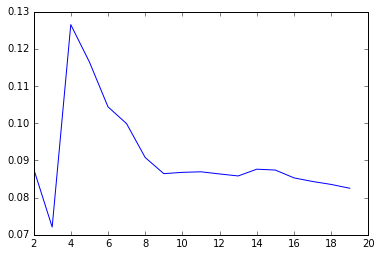

In [29]:
def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        everything.append(metrics.homogeneity_score(clf.predict(X_test),y_test))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.homogeneity_score(clf.fit_predict(X_touse),y))
    return np.mean(everything), np.std(everything)

#print clusteringscore(KMeans, n_clusters=4) # Use MiniBatchKMeans is Kmeans is too slow
#print clusteringscore(AffinityPropagation)
#print clusteringscore(MeanShift)
#print clusteringscoreFitPredict(SpectralClustering)
#print clusteringscoreFitPredict(AgglomerativeClustering, n_clusters=2)
#print clusteringscoreFitPredict(DBSCAN)
#print clusteringscore(Birch)
hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

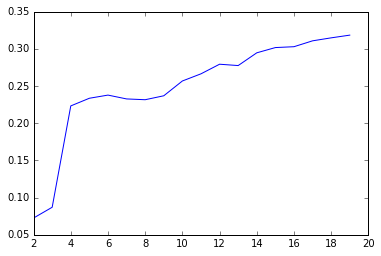

In [30]:
def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        everything.append(metrics.completeness_score(clf.predict(X_test),y_test))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.completeness_score(clf.fit_predict(X_touse),y))
    return np.mean(everything), np.std(everything)

#print clusteringscore(KMeans, n_clusters=4) # Use MiniBatchKMeans is Kmeans is too slow
#print clusteringscore(AffinityPropagation)
#print clusteringscore(MeanShift)
#print clusteringscoreFitPredict(SpectralClustering)
#print clusteringscoreFitPredict(AgglomerativeClustering, n_clusters=2)
#print clusteringscoreFitPredict(DBSCAN)
#print clusteringscore(Birch)
hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

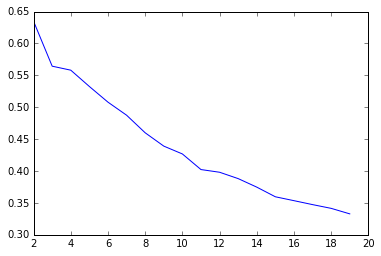

In [31]:
def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)
        X_train, X_test = scaleData(X_train, X_test)
        clf.fit(X_train)
        everything.append(metrics.fowlkes_mallows_score(clf.predict(X_test),y_test))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.fowlkes_mallows_score(clf.fit_predict(X_touse),y))
    return np.mean(everything), np.std(everything)

#print clusteringscore(KMeans, n_clusters=4) # Use MiniBatchKMeans is Kmeans is too slow
#print clusteringscore(AffinityPropagation)
#print clusteringscore(MeanShift)
#print clusteringscoreFitPredict(SpectralClustering)
#print clusteringscoreFitPredict(AgglomerativeClustering, n_clusters=2)
#print clusteringscoreFitPredict(DBSCAN)
#print clusteringscore(Birch)
hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

#### If cluster answer is not known (we do not have a y)
These metrics tell you whether your clusters and dense and separated, i.e. are well-defined clusters, when viewed from the perspective of the given model

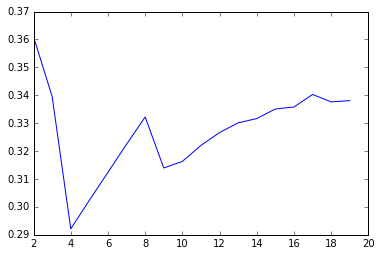

In [45]:
def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X, X)[0]
        clf.fit(X_touse)
        everything.append(metrics.silhouette_score(X_touse, clf.predict(X_touse)))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.silhouette_score(X_touse, clf.fit_predict(X_touse)))
    return np.mean(everything), np.std(everything)

hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

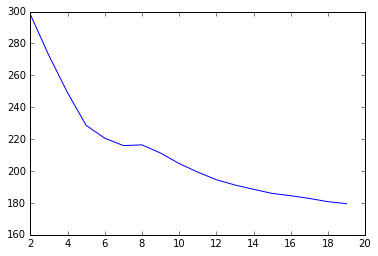

In [46]:
def clusteringscore(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X, X)[0]
        clf.fit(X_touse)
        everything.append(metrics.calinski_harabaz_score(X_touse, clf.predict(X_touse)))
    return np.mean(everything), np.std(everything)

def clusteringscoreFitPredict(method, **kwargs):
    everything = []
    for ij in range(60):
        clf = method(**kwargs)
        X_touse = scaleData(X,X)[0]
        everything.append(metrics.calinski_harabaz_score(X_touse, clf.fit_predict(X_touse)))
    return np.mean(everything), np.std(everything)

hoho = [clusteringscore(KMeans, n_clusters=kk)[0] for kk in range(2,20)]
plt.plot(range(2,20), hoho)

# Feature Engineering

In [21]:
numericdataframe = makeAllColumnsNumeric(thedataframe, dictofordinals, datacateg)[0]
topredict = "Survived"
frompredict = ['Sex', 'Fare', 'Pclass', 'Age', 'SibSp', 'Cabin', 'Embarked', 'Parch']
(X,y) = makeDataFromModels(numericdataframe, topredict, frompredict, {})

### Remove features uncorrelated with y
SelectKBest choses the $k$ columns in $X$ that are most correlated with the answer $y$, using as method to determine correlation anything we want. mutual_info_classif is a good default one: it uses KnearestNeighbors to determine how correlated things are.

In [17]:
numfeaturestokeep = 4 # tune this to whatever you like

# if predicting y is a regression rather than classification problem, we should use mutual_info_regression
X_reduced = SelectKBest(mutual_info_classif, k=numfeaturestokeep).fit_transform(X, y)

getPredictionScore(X_reduced, y, RandomForestClassifier, num_iterations=10, transform="none", n_estimators=30)

(0.80285454545454538, 0.029110362697740397)

Instead of taking all columns at once, we iteratively check which column is the worst predictor and remove it, until we have the desired number of features (in the case of RFE) or we have the ideal number of features (in the case o RFECV). You can pass both a regressor, with attribute coef\_, or a classifier that has the attribute feature\_importances\_  

In [48]:
estimator = linear_model.LinearRegression()
selector = RFE(estimator, 5, step=1)
selector.fit(X, y)
print selector.score(X, y)
selector.support_ 

0.381556005259


array([ True, False,  True, False,  True,  True,  True, False], dtype=bool)

In [61]:
estimator = RandomForestClassifier(n_estimators=30)
selector = RFECV(estimator, cv=5)
selector.fit(X, y)
print cross_val_score(selector, X, y, cv=5)
selector.support_

[ 0.77272727  0.81714286  0.82857143  0.76        0.87428571]


array([ True,  True,  True,  True, False,  True, False, False], dtype=bool)

### Use trees to find feature importances

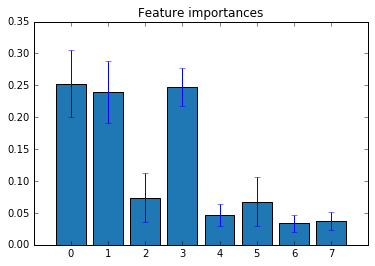

In [81]:
forest = RandomForestClassifier(n_estimators=200)
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances,
       color=brewerColors(1), yerr=std, align="center")
plt.xticks(range(X.shape[1]), )
plt.xlim([-1, X.shape[1]])
plt.show()

### Feature selection functions

In [121]:
# With a given list frompredict, it will return the subset of the entries in frompredict that yield
# the best prediction with the model predictionmethod.
def bestFeatureSet(numericdataframe, topredict, frompredict, predictionmethod,
                   dictofunknown={}, num_iterations=100, transform="none"):
    bestscore = 0
    bestsubset = []
    for ii in range(1,len(frompredict)):
        allsubsets = findsubsets(frompredict,ii)
        allsubsets = [list(subset) for subset in allsubsets]
        for subset in allsubsets:
            (X,y) = makeDataFromModels(numericdataframe, topredict, subset, dictofunknown)
            score = getPredictionScore(X, y, predictionmethod, num_iterations=num_iterations, transform=transform)
            if score[0]>bestscore:
                bestscore = score[0]
                bestsubset = subset
    return bestsubset

#### Helper functions

In [ ]:
def findsubsets(set,sizeofsubset):
    return set(itertools.combinations(set, sizeofsubset))

### Dimensional reduction functions

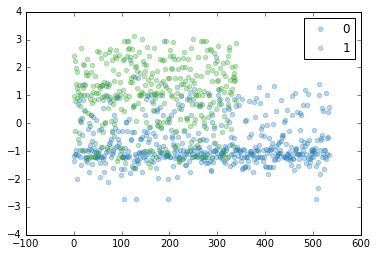

In [92]:
# LDA is supervised, PCA is not. LDA tries to separate the classes as much as possible from each other while doing dim red;
# PCA tries to separate the data as much as possible from itself (no labels) when doing dim red.
def dimensionalReductionLDA(X, y):
    clf = LinearDiscriminantAnalysis(n_components=2)
    clf.fit(X,y)
    trans_X = clf.transform(X)
    uniquevalues = list(set(y))
    for ii in uniquevalues:
        if trans_X.shape[1]==1:
            xaxisnumbers = range(len(trans_X[y==ii]))
            yaxisnumbers = trans_X[y==ii, 0]
        else:
            xaxisnumbers = trans_X[y==ii, 0]
            yaxisnumbers = trans_X[y==ii, 1]
        plt.scatter(xaxisnumbers, yaxisnumbers, alpha=0.3, color=brewerColors()[ii], label=ii)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    

dimensionalReductionLDA(X,y)

In [180]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, MDS, TSNE

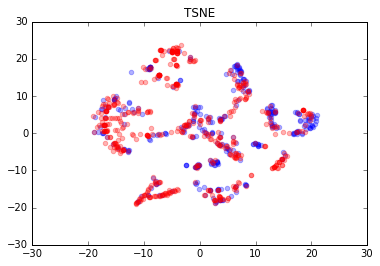

In [182]:
X_touse = scaleData(X,X)[0]
def plot2d(chosenmodel, **kwargs):
    clf = chosenmodel(**kwargs)
    newX = clf.fit_transform(X_touse)
    madeit = newX[np.where(y==1)[0]]
    notmadeit = newX[np.where(y==0)[0]]
    plt.scatter(madeit[:,0],madeit[:,1], color="b", alpha=0.3)
    plt.scatter(notmadeit[:,0],notmadeit[:,1], color="r", alpha=0.3)
    plt.title(getModelName(chosenmodel))
    plt.show()
    
plot2d(Isomap, n_neighbors=3) #Maintains geodesic distances between nearby points, "unravelling" the whole manifold
plot2d(LocallyLinearEmbedding, n_neighbors=5) #Locally maints distances, "unravelling" the manifold in 
                                               #a similar but different way to Isomap
plot2d(SpectralEmbedding, affinity="nearest_neighbors") #Takes the dominant eigenvectors of the Laplacian matrix
plot2d(MDS, metric=False) #Is good at preserving the hierarchy of distances of the high-dim space
plot2d(MDS) #Is good at preserving distances of the high-dim space
plot2d(TSNE) #Is good at preserving local structure - it focuses on the  details of the high-dim space. It can deal
             #with multiple, disjoint manifolds

In [219]:
from  sklearn.decomposition import PCA, KernelPCA, SparsePCA

[ 2.47070807  1.73187736  1.00165249  0.85269516  0.705099    0.56046737
  0.44053465  0.2369659 ]


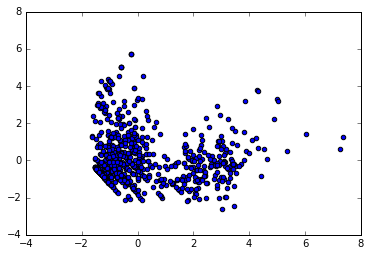

In [220]:
X_touse = scaleData(X,X)[0]

pca = PCA()
newX = pca.fit_transform(X_touse)
plt.scatter(newX[:,0],newX[:,1])
print pca.explained_variance_ 

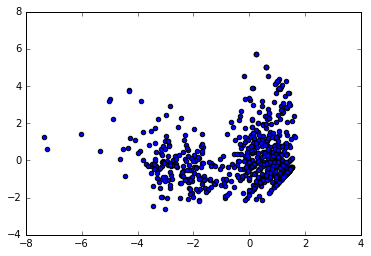

In [221]:
pca = KernelPCA()
newX = pca.fit_transform(X_touse)
plt.scatter(newX[:,0],newX[:,1])

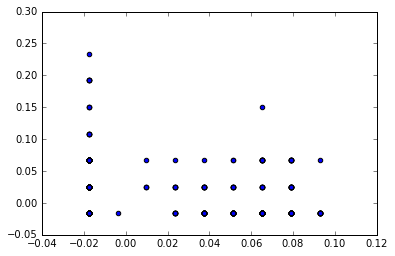

In [222]:
pca = SparsePCA()
newX = pca.fit_transform(X_touse)
plt.scatter(newX[:,0],newX[:,1])

##### Still to do:
 - Make a generic evaluaion of how each model did. It should include confusion matrices, ROC curves, time it takes to .fit (or possibly it's better to do "speed"= # of examples/time), time it takes to .predict (or perhaps "speed" again), accuracy (.score for supervised, various metrics."scoringmethod" for unsupervied), plot of heteroscedasticity, plot of calibrated probability esimates
 - Compare with histograms etc. the various models against each other, and draw a horizontal line in the histograms where the benchmark value is, i.e. the score of a "random prediction"
 - Check what else we did during S2DS
 - FOR EACH MODEL, DO A GRIDSEARCH TO FIND ITS BEST VALUES, INCLUDING VARIOUS SOLVER FUNCTIONS ETC. ALSO, TRY THE SAME PROCEDURE FOR THE CASE WHERE CATEGORICAL DATA IS NUMBERED 1,2,3,.. AND FOR THE CASE WHERE CATEGORICAL DATA IS SPLIT INTO SEVERAL COLUMNS, EACH ONLY TAKING THE VALUE 0,1 (E.G. Pclass being three columns, all taking the value zero except for the actually correct class, which takes the value 1)